# Introduction

Suppose we are studying a chemical reaction and wish to optimize a fluorescence
measurement $f(\mathbf x, t)$, which we view as a response function with respect
to the initial concentrations of reaction precursors $\mathbf x$, and reaction
time $t$. For a single choice of concentrations $\mathbf x$ (i.e. a choice of
**action**), we obtain $n$ observations of the response in the form of the
time-series:

$$f(\mathbf x, t_1), f(\mathbf x, t_2), ..., f(\mathbf x, t_n)$$

We assume the observation times $t_1, ..., t_n$ are the same for all reactions.

The optimization **objective** is to identify the conditions $(\mathbf x^\star,
t^\star)$ that optimize the response $f$. That is, we wish to identify the
maximum value:

\begin{align}
       \max_{\mathbf x, t} f(\mathbf x, t)
           &= \max_{\mathbf x} \max_t f(\mathbf x, t) \\
           &= \max_{\mathbf x} u_\text{max}(\mathbf x)
\end{align}

where $u_\text{max}(\mathbf x) = \max_t f(\mathbf x, t)$ is called a utility
function. It is a special type of utility function called an aggregate utility
function, which is one that reflects an aggregate or summary statistic of the
values $f(\mathbf x, t)$ for $t = t_1, ..., t_f$. In this case, the aggregation
is the **$\max$** operator, but we could also consider operators or summary
statistics as well. Examples include: mean, median, upper confidence bound (UCB)
, and total variation.

To perform this optimization in a closed loop, we wish to iteratively select
actions $\mathbf x$ to eventually identify the optimal concentrations, $\mathbf
x^\star$, and time $t^\star$. Below we will outline some approaches to this
problem.

## Generate data (for illustration only)

First, we generate a small toy dataset to work. In reality, this data comes from
our experiments. For this example, however, we will  use a synthetic toy problem
to generate our "experimental" data. The ground truth response function is

$$ f(x, t) = \sin(50t) \exp\left[-\frac{(x-t)^2}{2\cdot \ell_1^2}\right] \exp\left[-\frac{(x-\theta)^2}{2\cdot \ell_2^2}\right]$$

where $\theta, \ell_1$ and $\ell_2$ are parameters.

In [1]:
import numpy as np

def f_truth(x, t, theta):
    return np.sin(50*t)*\
           np.exp(-0.5*((x-t)/0.2)**2) * \
           np.exp(-0.5*((x-theta)/0.3)**2)

For specific values of $\theta$, $\ell_1$ and $\ell_2$, we can plot this
response function over the domain of $x$ and $t$ values, both variables
being between 0 and 1.

Text(0.5, 263.1666666666663, '$t$')

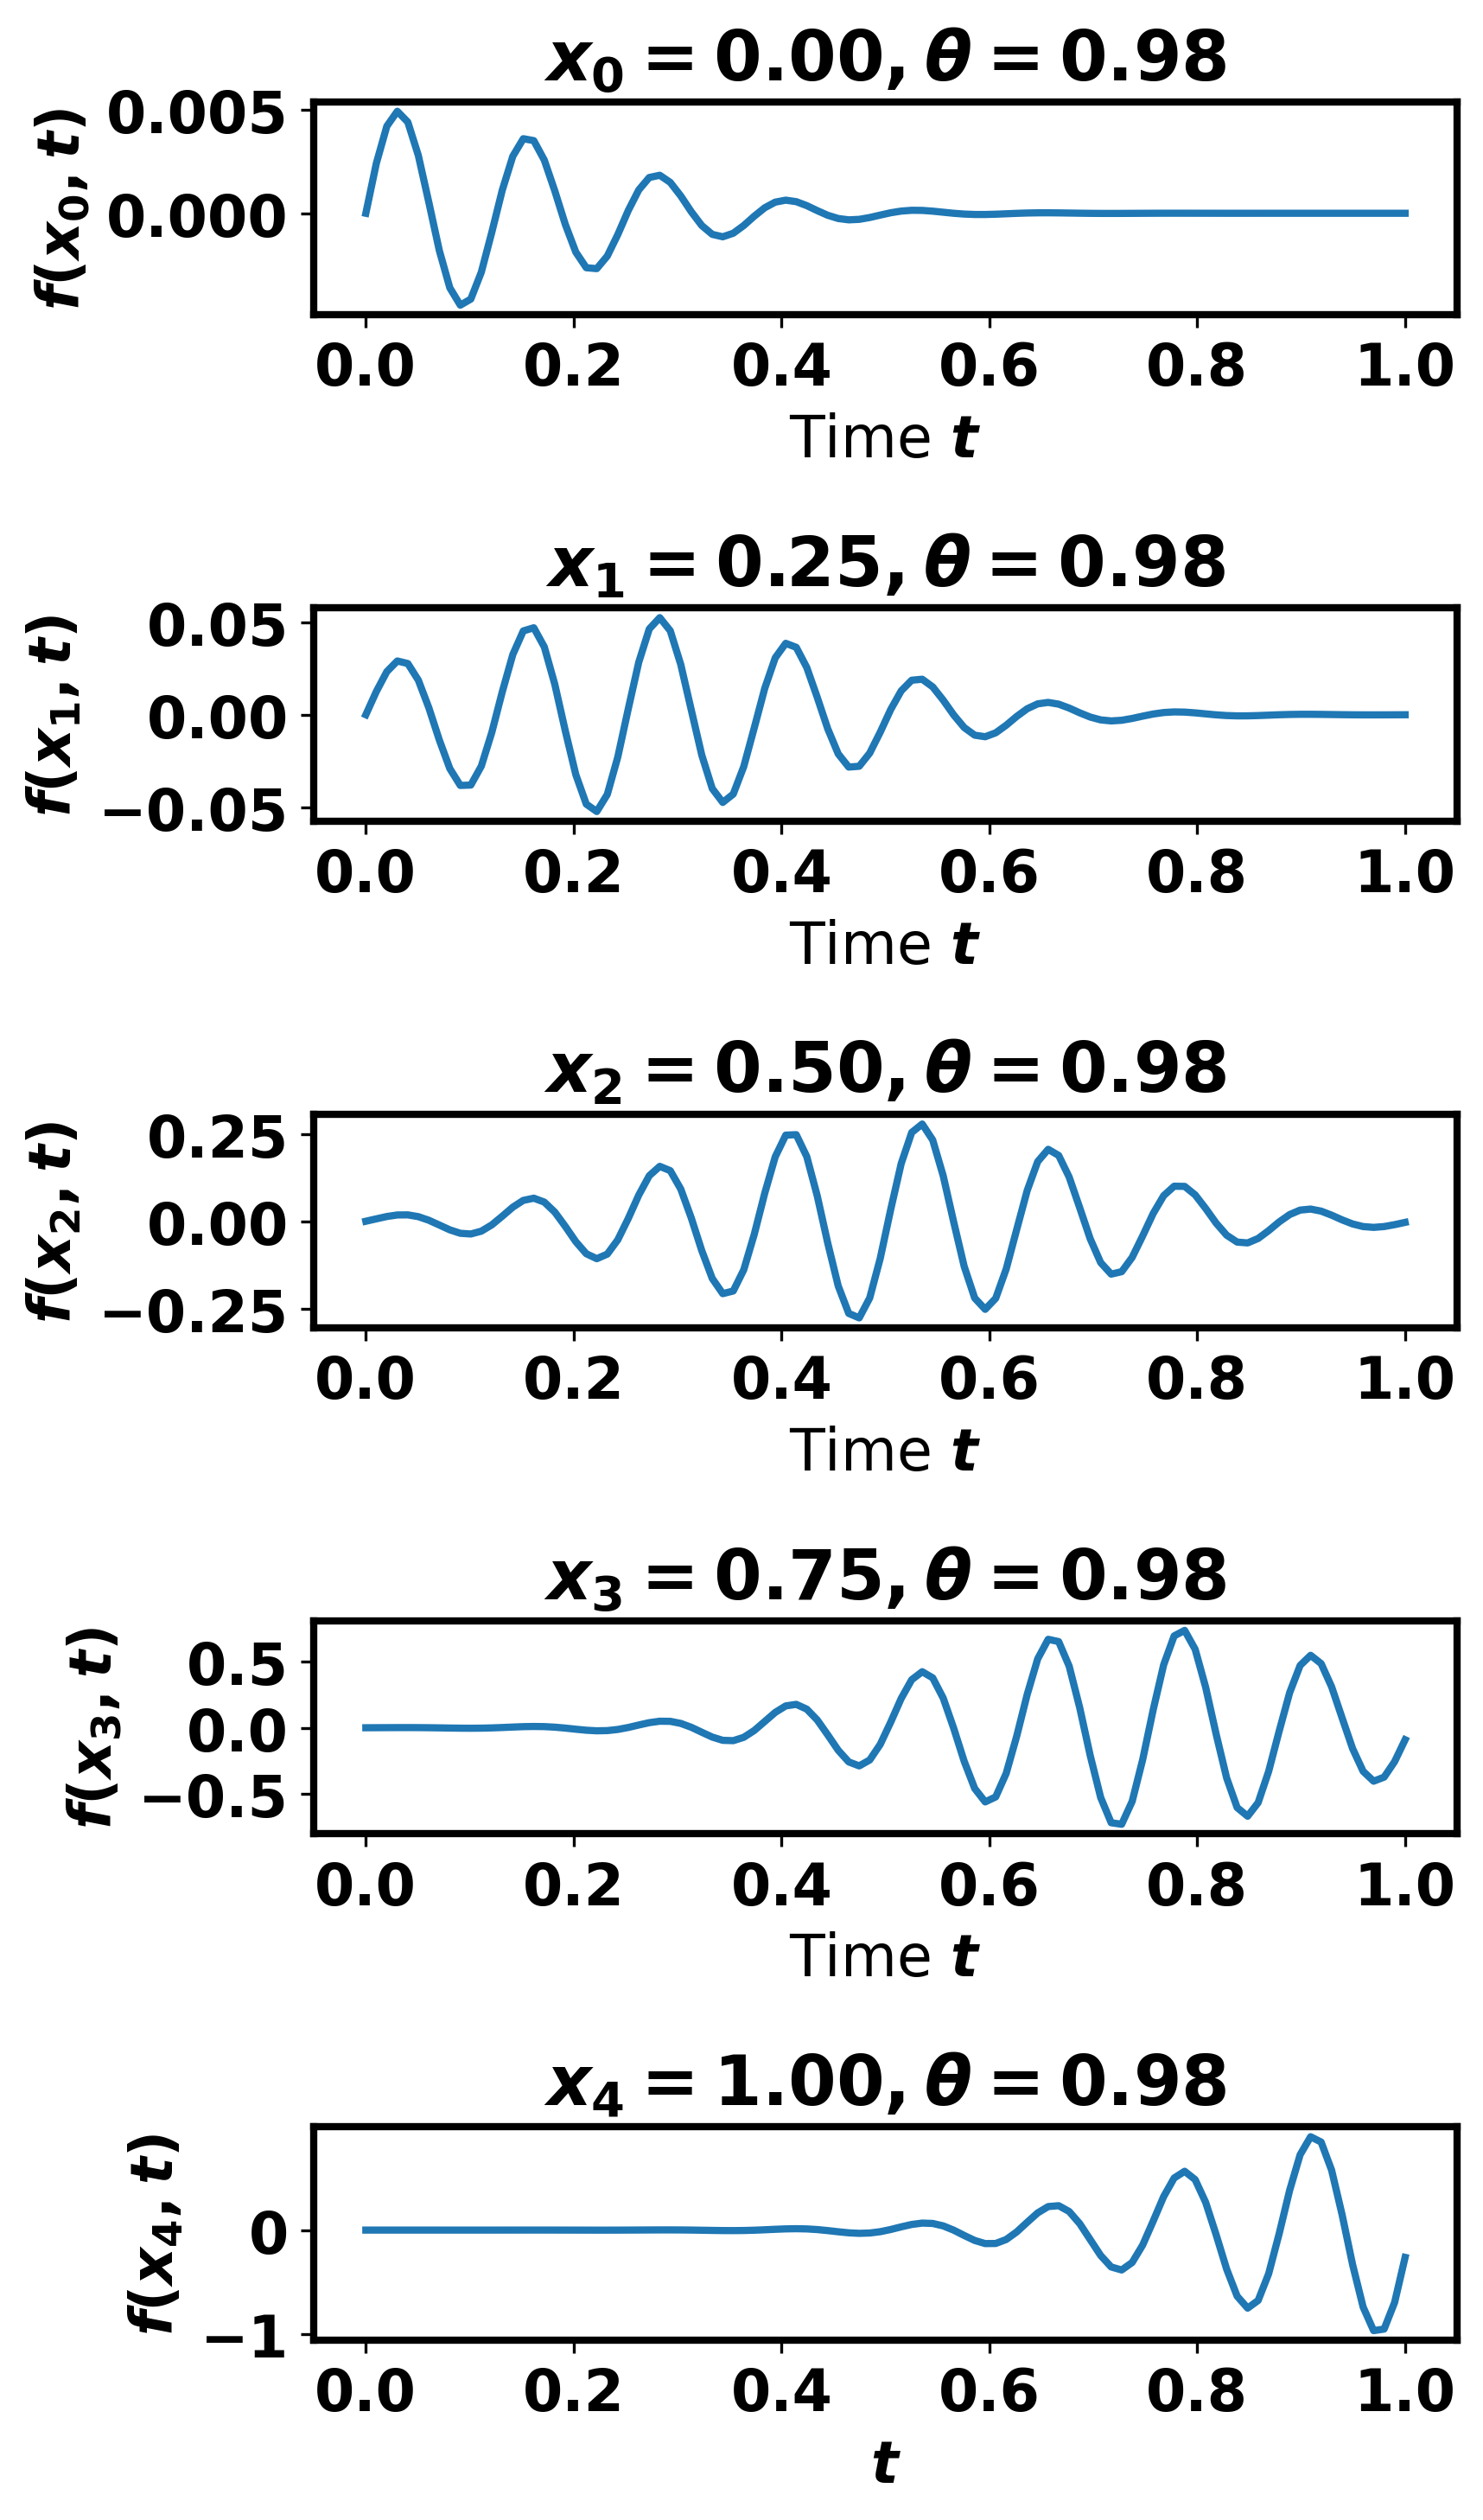

In [32]:
# Some boilerplate code to make plots, feel free to ignore
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.facecolor'] = 'w'
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['font.size'] = 16
mpl.rcParams['font.weight'] = 'bold'
# End boilerplate code

# Pick some random parameters as the "ground truth"
rng = np.random.default_rng(seed=1234)
theta_star = rng.uniform()

x_sample = np.linspace(0, 1, 5) # Sample five different x values
t_plot = np.linspace(0, 1, 100) # The times t_1, t_2, ..., t_n

# Plot the ground truth for the different x values, over time
plt.figure(figsize=(6, 2*len(x_sample)))
for i, x_i in enumerate(x_sample):
    y_truth = f_truth(x_i, t_plot, theta_star)
    plt.subplot(len(x_sample), 1, i+1)
    plt.title(r'$x_%d = %4.2f, \theta = %4.2f$'%(i, x_i, theta_star))
    plt.plot(t_plot, y_truth)
    plt.xlabel('Time $t$')
    plt.ylabel(r'$f(x_%d, t)$'%i)

plt.tight_layout()
plt.xlabel('$t$')

For any choice of $x$, the function is maximized near $t = x$. The function is
globally maximized when $x$ is near $\theta$. From this function, we'll obtain
slightly noisy data.

Now we generate the training data that we'll use for the examples below. We
fix the observation times $t_1, ..., t_n$ for $n=25$ equally spaced points
between 0.1 and 1. We then sample 5 different concentration vectors $\mathbf x$.
We then form the $5 \times 25$ matrix of observation values called `obs` below.
The entry `obs[i][j]` is the observation $f_(x_i, t_j)$.

We also define the maximum observed value for each reaction in an array `u_obs`.
This is a $5\times 1$ matrix, where entry `u_obs[i][0]` is the maximum response
for the $i$-th reaction: $u(\mathbf x_i) = \max_t f(\mathbf x_i, t)$.

To pass this data to the API, we must make sure our observations (either `obs`
or `u_obs`) and our actions (here the list of $\mathbf x_i$) are two-dimensional
lists. We also pass the observation times $t_1, ..., t_n$ to Holmes as a 2D
list as well.


In [3]:
t_data = np.linspace(0.1, 1, 25) # 25 time points each reaction
x_data = rng.uniform(0, 1, size=(5,1)) # 5 different concentrations initially

# Observation data = response for each time
obs = [[f_truth(x, t, theta_star).item() for t in t_data] for x in x_data]

# The "observations" of the maximum values
u_obs = np.max(obs, axis = 1)[:, np.newaxis]

# Action data = concentration
actions = x_data.tolist()

# The observation times list, as a 2D array
time_points = t_data[:,np.newaxis].tolist()

Again, in reality, this data comes from your experiments. Now that we have our
data, below we explore different ways to model the problem and call Holmes.


# Model 0

The most classic way of modeling this problem is as a vanilla optimization
problem: maximize $u(\mathbf x)$.

That is, instead of viewing the values $f(\mathbf x, t_i)$ as the observable
responses, we treat the maximum value, $u(\mathbf x)$ as the response. In this
case, our data consists of the actions $\mathbf x_i$, and the maximum response
value observed for each reaction, $u(\mathbf x_i)$. This method is easy to
model, and invoking Holmes is straight forward. Simply pass Holmes the data
matrix of results from $N$ experiments:

\begin{pmatrix}
   -\mathbf x_1- &  u(\mathbf x_1) \\
   -\mathbf x_2- &  u(\mathbf x_2) \\
   \vdots        &  \vdots \\
   -\mathbf x_N-&  u(\mathbf x_N)
\end{pmatrix}


In [4]:
import requests
import pprint

# The data matrix concatenate the x data and u_obs data as columns
data = np.hstack((x_data, u_obs)).tolist()

# The actual request
BASE_URL = "http://127.0.0.1:5000/holmes"
res = requests.post(BASE_URL + "/basic/suggest", json = data).json()

# Print the results
pprint.pprint(res)

{'suggestions': [{'policy': 'xplt', 'suggestion': [[0.813777117063816]]},
                 {'policy': 'maxvar', 'suggestion': [[0.7842939163053224]]},
                 {'policy': 'mcei', 'suggestion': [[0.7952060583970897]]}]}


While this method is easy to model, it has some limitations. First, we throw
away a lot of data. For each reaction we essentially keep one data point (the
maximum response value), and discard the rest. This procedure is wasteful.
We should try to use all the data we have.

The second limitation has to do with the statistical assumptions underpinning
the models used internally in Holmes. Many models in Holmes assume observations
are made with a specific type of noise: additive Gaussian noise. If the
true observations $f(\mathbf x, t)$ have this type of noise, the nonlinear
transformation $u(\mathbf x) = \max_t f(\mathbf x, t)$ will **not** have this
type of noise.

Sometimes this may be acceptable -- especially if we can "encapsulate"
the true, non-linear noise with an additive Gaussian one, or if the noise is
small. Other times, we can try to mimic additive Gaussian noise by performing
replicates. That is, for each $\mathbf x$, obtain $u(\mathbf x)$ by performing
the experiment $m$ times, and averaging the $m$ maximum values observed.
Doing so tends to make the distribution of responses closer to the assumed
Gaussian one.

Now, we will consider other methods that allow us to use all the data obtained
during a reaction.

# Model 1

One alternative way to model this problem is to view the response function as an
$n$-dimensional, vector-valued function. Because Holmes is multivariate by
default, we can use most built-in models to capture this multi-dimensional
response.

$$\mathbf f(\mathbf x) = (f(\mathbf x, t_1), ..., f(\mathbf x, t_n)).$$

Of course, while we model the entire time series, we are still interested in
original optimization problem: finding the single response that is maximum.
Hence, we will specify a policy that uses this full time-series model, but is
cognizant of scalar objective.

Below, we set up the models to call the API. We'll have to provide model
specifications as well as our data. To set up the problem, we must
specify two main models:

1. The model for the multivariate response function and,
2. A decision-making policy to select experiments with the goal of finding the
   optimal single response.

We define these models (and auxiliary models) inside the `model_specs`
dictionary of our request. We'll build up the request sequentially to explain
each part. The request will have the three main entries: `model_specs` defines
models specifications, `policies` is a list of policies to use to suggest the
next actions, and `data_sources` contains our data. We initialize this
last entry with our actual data.

In [5]:
mcei_request = {
    'model_specs': {},
    'policies': [],
    'data_sources': {
        "actions[action_type]": actions,
        "obs[obs_type]": obs
    }
}

Now we define our models. First, we define our model for the multi-variate
response function. Here, we specify the observation points in the `task_cov`
parameter. Doing this tells Holmes that our response model is multivariate,
with each response corresponding to a time point.

In [6]:
mcei_request['model_specs']['state'] = {
    "name": "holmes.state.GPBeliefState",
    "params": {
        "data[as_action_obs_data]": {
            "actions[scale_to_zero_one]": "<actions>",
            "obs[z_to_standard_z, bounded_to_z]": "<obs>" },
        "task_cov[exp_cov_mat]": { "inputs": time_points }
    }
}

Next we specify our policy. We'll do this in three steps. First we define our
utility function, which states we are ultimately interested in optimizing the
maximum response value over a time series. Next we use that utility function
inside an **acquisition function**, which is how we score potential experiments
$\mathbf x$ to run. We lastly take this acquisition function and place it inside
a policy that says the suggested experiment is the one with the highest score.

In [7]:
# The max utility function
mcei_request['model_specs']['max_utility_f'] = {
    "name": "holmes.policies.MaxUtilityFunction"
}

# The acquisition function / scoring function
mcei_request['model_specs']['max_mcei_acq_f'] = {
    "name": "holmes.policies.MCEIAcq",
    "params": {
        "num_mc_samples": 128,
        "rng": "{_rng}",
        "utility_f": "{max_utility_f}"
    }
}

# The policy
mcei_request['model_specs']['max_mcei'] = {
    "name": "holmes.policies.AcquisitionFunctionPolicy",
    "params": {
        "acq_f": "{max_mcei_acq_f}",
        "optimizer": "{optimizer}"
    }
}

Once we define the policy model, we tell Holmes to use this policy to make
suggestions. This is done by populating the `policy` list with a reference to
the policy we just defined.

In [8]:
mcei_request['policies'].append("{max_mcei}")

Lastly, we define the number of total experiments as an action budget. This
total number of experiments includes the number of actions already present
in the data. In our case, we have 5 actions in the data (5 reactions), and we
suppose we want to do about 10 more actions in our campaign. Hence, we specify
a value of 15 for our action budget.

In [9]:
mcei_request['model_specs']['action_budget'] = 15

Once the request has been built, we can send it to the Holmes API.

In [10]:
# Send request
mcei_res = requests.post(BASE_URL + "/basic/suggest",
                         json = mcei_request).json()

# Print response
pprint.pprint(mcei_res)

{'suggestions': [{'policy': 'max_mcei', 'suggestion': [[0.4671880766349997]]}]}


We see that Holmes returns a single suggest provided by the policy we built
above.

### The entire request in a single definition

For reference, here is the entire request as a singly defined dictionary.

In [11]:
mcei_request = {
    "model_specs": {
        "state": {
            "name": "holmes.state.GPBeliefState",
            "params": {
                "data[as_action_obs_data]": {
                    "actions[scale_to_zero_one]": "<actions>",
                    "obs[z_to_standard_z, bounded_to_z]": "<obs>" },
                "task_cov[exp_cov_mat]": { "inputs": time_points } } },

        "max_mcei": {
            "name": "holmes.policies.AcquisitionFunctionPolicy",
            "params": {
                "acq_f": "{max_mcei_acq_f}",
                "optimizer": "{optimizer}" } },

        "max_mcei_acq_f": {
            "name": "holmes.policies.MCEIAcq",
            "params": {
                "num_mc_samples": 128,
                "rng": "{_rng}",
                "utility_f": "{max_utility_f}"} },

        "max_utility_f": { "name": "holmes.policies.MaxUtilityFunction" },

        "action_budget":  15 },

    "data_sources": { "actions[action_type]": actions, "obs[obs_type]": obs },

    "policies": ['{max_mcei}']
}

## What's going on underneath the hood

Internally, Holmes uses a probabilistic model called `GPBeliefState`. This model
is a probability distribution of the multivariate response function

$$\mathbf f(\mathbf x) = (f(\mathbf x, t_1), ..., f(\mathbf x, t_n).$$

The assumption is that we don't actually know the function $f(\mathbf x, t)$
completely (otherwise we wouldn't need to do any experiments). Hence, the
model represents **probability beliefs** about what that function is, given the
data we currently have. Using this model, for any given $\mathbf x$, we
calculate values

$$\mathbf \mu(\mathbf x) = (\mu_1(\mathbf x), ... \mu_n( \mathbf x),$$

whose $i$-th entry is the **expected (or average) value**:

$$\mu_i(\mathbf x) = \mathbb E\left[f(\mathbf x, t_i)\right]. $$

This value is the average value of $f(\mathbf x, t_i)$ defined by probability
distribution. These entries are estimate of the response at different times.

Internally, we also calculate a **covariance matrix** $\Sigma(\mathbf x)$,
whose $(i,j$)-th entry is the covariance

$$\Sigma(\mathbf x)_{i,j} = \text{Cov}(f(\mathbf x, t_i), f(\mathbf x, t_j)).$$

Covariances measure the statistical relationship between the responses at
different times, as well as provide an uncertainty quantification ("error bars")
of the estimates $\mu_i(\mathbf x)$. (Using the `GPBeliefState` model,
we in fact encode the relationship of the responses between different times
**and concentrations**.)

Using this probabilistic model for $\mathbf f(\mathbf x)$, we can use a policy
to select the next $\mathbf x$. Above, we used the `MCEI` policy, which is one
of a few policies that can accept a (non-linear) utility function $u$. Given the
model for $\boldsymbol f$, the MCEI policy computes a score for each $\mathbf
x$:

$$\text{Score}_{EI}(\mathbf x) = \mathbb E\left[ u_\text{max}(\mathbf x) - u_\text{best} \right]^+$$

where $u_\text{best}$ is the best observed value of $f(\mathbf x, t)$ for any
$\mathbf x$ and $t$ in our data set. This is the acquisition function referred
to above when we were building our request.

Here, the expectation $\mathbb E$ means averaging over the possible values for
the responses $\mathbf f(\mathbf x)$, and hence averaging over the possible
values for $u_\text{max}(\mathbf x)$. The $+$ in the exponent means evaluate to 0 if the
quantity in the bracket is negative. The `MCEI` policy computes this expectation
by sampling several responses for any given $\mathbf x$, where we obtain samples
according to the probabilistic model defined above.

# Model 0 vs. Model 1

We have defined two models. Which one is better for this problem? To answer this
question, we can perform simulations of the campaign for both models.
Simulations try to predict the future campaign performance given prior data. We
can call the Holmes endpoint `/basic/simulate` to run such simulations on the
server, and then analyze the returned results. The request for this endpoint is
similar to the one for `/basic/suggest`. We define a simulation quantity of
interest (QOI) that measures performance of a campaign, and some additional
simulation parameters.

To set up our call to the simulation endpoint, we first copy the request we
sent to `/basic/suggest`. We will add more specifications to this request.
First, we specify a performance metric as a model in `model_specs`, and pass
along the utility function to convert observable response to the quantity we
wish to maximize. The performance metric we'll use is called Opportunity Cost
(OC), which is a metric for optimization campaigns.

## Model 0 Simulations

To perform the simulations for Model 0, we have to change the request a little
so that we can specify the QOI model and the simulation parameters. We'll
still pass the data matrix in an entry called `data_raw`. We specify the
OC model inside `model_specs`. Lastly, we provide simulation parameters
in `sim_params`, notably requesting 64 simulations per policy.

In [12]:
data = np.hstack((x_data, u_obs)).tolist()
basic_sim_request = {
    "data_raw": data,

    'model_specs': {
        'oc': {
            "name": "holmes.simulator.qois.OpportunityCost",
            "params": {
                "optimizer": "{optimizer}",
                "rng": "{_rng}",
                "sim_fmodel": "{fmodel}",
            }
        },

        "action_budget":  15
    },

    'sim_params': {
        "num_sims": 128, # Run 128 simulations per policy
        "qoi_freq": 2, # Calculate sim QOI every 2 steps
        "qois": ["{oc}"], "y_qoi": "oc" # Compute and return OC as the QOI
    }
}

Now that we defined the request, we can send it to the Holmes API. Simulations
are computationally expensive to run, so calls to the simulation endpoint tend
to take a long time. Currently, these calls **block**. That is, the HTTP client
will wait until all simulations are done to return the simulation results. In
the future, this call will be split into two **asynchronous** calls. The first
one begins simulation execution, while the second one retrieves simulation
results once simulations are done. For now, however, we call the single endpoint
and just wait for the results. For comparison with other models, we'll measure
how long it takes to run the simulations

In [13]:
import timeit

# Send request
tic = timeit.default_timer()
basic_sim_res = requests.post(BASE_URL + "/basic/simulate",
                              json = basic_sim_request).json()
toc = timeit.default_timer()

print("Elapsed time = %4.2f seconds"%(toc - tic))

Elapsed time = 2084.77 seconds


Because we didn't specify which policies to try, by default Holmes considers
a few default policies. The simulation endpoint simulates the performance of
these default policies and returns the performance metric as a function of
number of actions by default. We can plot these simulation results to compare.
We'll put the plotting code in a separate function for reuse later.

In [14]:
# Plot results
import matplotlib.pyplot as plt

def fit_decay_model(x, y):
    """ Fits an exponential decay model: log(oc) = -lambda*t + log(A) """

    log_y = np.log(y + 1e-6)
    Phi = np.array([np.ones(len(y)), x]).T
    sol = np.linalg.lstsq(Phi, log_y, rcond=None)
    lamb = -1.0*sol[0][1]
    A = np.exp(sol[0][0])
    return lamb, A

def plot_sim_res(all_sim_res, ylim=None, ylog=False):
    """ Plots simulation results returned by the /basic/simulate endpoint. """
    decay_rates = []
    colors = []

    # Loop over the simulation results for each policy
    for sim_res in all_sim_res:
        policy = sim_res['policy']
        x = np.array(sim_res['qoi_dist']['x_qoi'])
        lo = np.array(sim_res['qoi_dist']['lo'])
        md = np.array(sim_res['qoi_dist']['md'])
        hi = np.array(sim_res['qoi_dist']['hi'])

        # plot median values, and save colors for decay rate plot
        h = plt.plot(x, md, label = policy)
        colors.append(h[0].get_color())

        # plot low and high envelope
        #plt.fill_between(x, lo, hi, color = h[0].get_color(), alpha=0.05)

        # fit exponential decay model and save decay rate
        lamb, A = fit_decay_model(x, md)
        decay_rates.append(lamb)
        print("%10s: %4.2f"%(policy, lamb))

    plt.xlabel('Number of actions')
    plt.ylabel('Opportunity cost')

    if ylim is not None:
        plt.ylim(ylim)
    if ylog:
        plt.yscale('log')

    # Plot decay rates for all policies, sorted from largest to smallest
    sorted_idx = np.argsort(decay_rates).tolist()
    decay_rates = [decay_rates[i] for i in sorted_idx]
    colors = [colors[i] for i in sorted_idx]
    policies = [all_sim_res[i]['policy'] for i in sorted_idx]

    # make bar plot / legend
    n = len(decay_rates)
    if ylog:
        ax = plt.gca().inset_axes([0.15, 0.05, 0.33, 0.075*n])
        _, x_max = plt.xlim()
        ax.set_title('Decay rate', fontsize=8)
    else:
        ax = plt.gca().inset_axes([0.6, 0.95-0.075*n, 0.33, 0.075*n])
        ax.set_xlabel('Decay rate', fontsize=8)
    y_locs = np.arange(n)
    ax.barh(y_locs, decay_rates, height=0.66, color=colors)

    scale = 0.2*np.max(decay_rates)
    for y, lamb in zip(y_locs, decay_rates):
        if lamb > scale:
            ax.text(lamb-scale, y - 0.15 , "%4.2f"%lamb,
                    color='w', fontsize = 8, fontweight='bold')
        else:
            ax.text(lamb + 0.01, y - 0.15 , "%4.2f"%lamb,
                    color='k', fontsize = 8)

    ax.set_xticks([])
    ax.set_yticks(y_locs, policies, fontsize=6)


We can then plot the simulation results:

      xplt: 0.64
    maxvar: 0.14
      mcei: 0.40


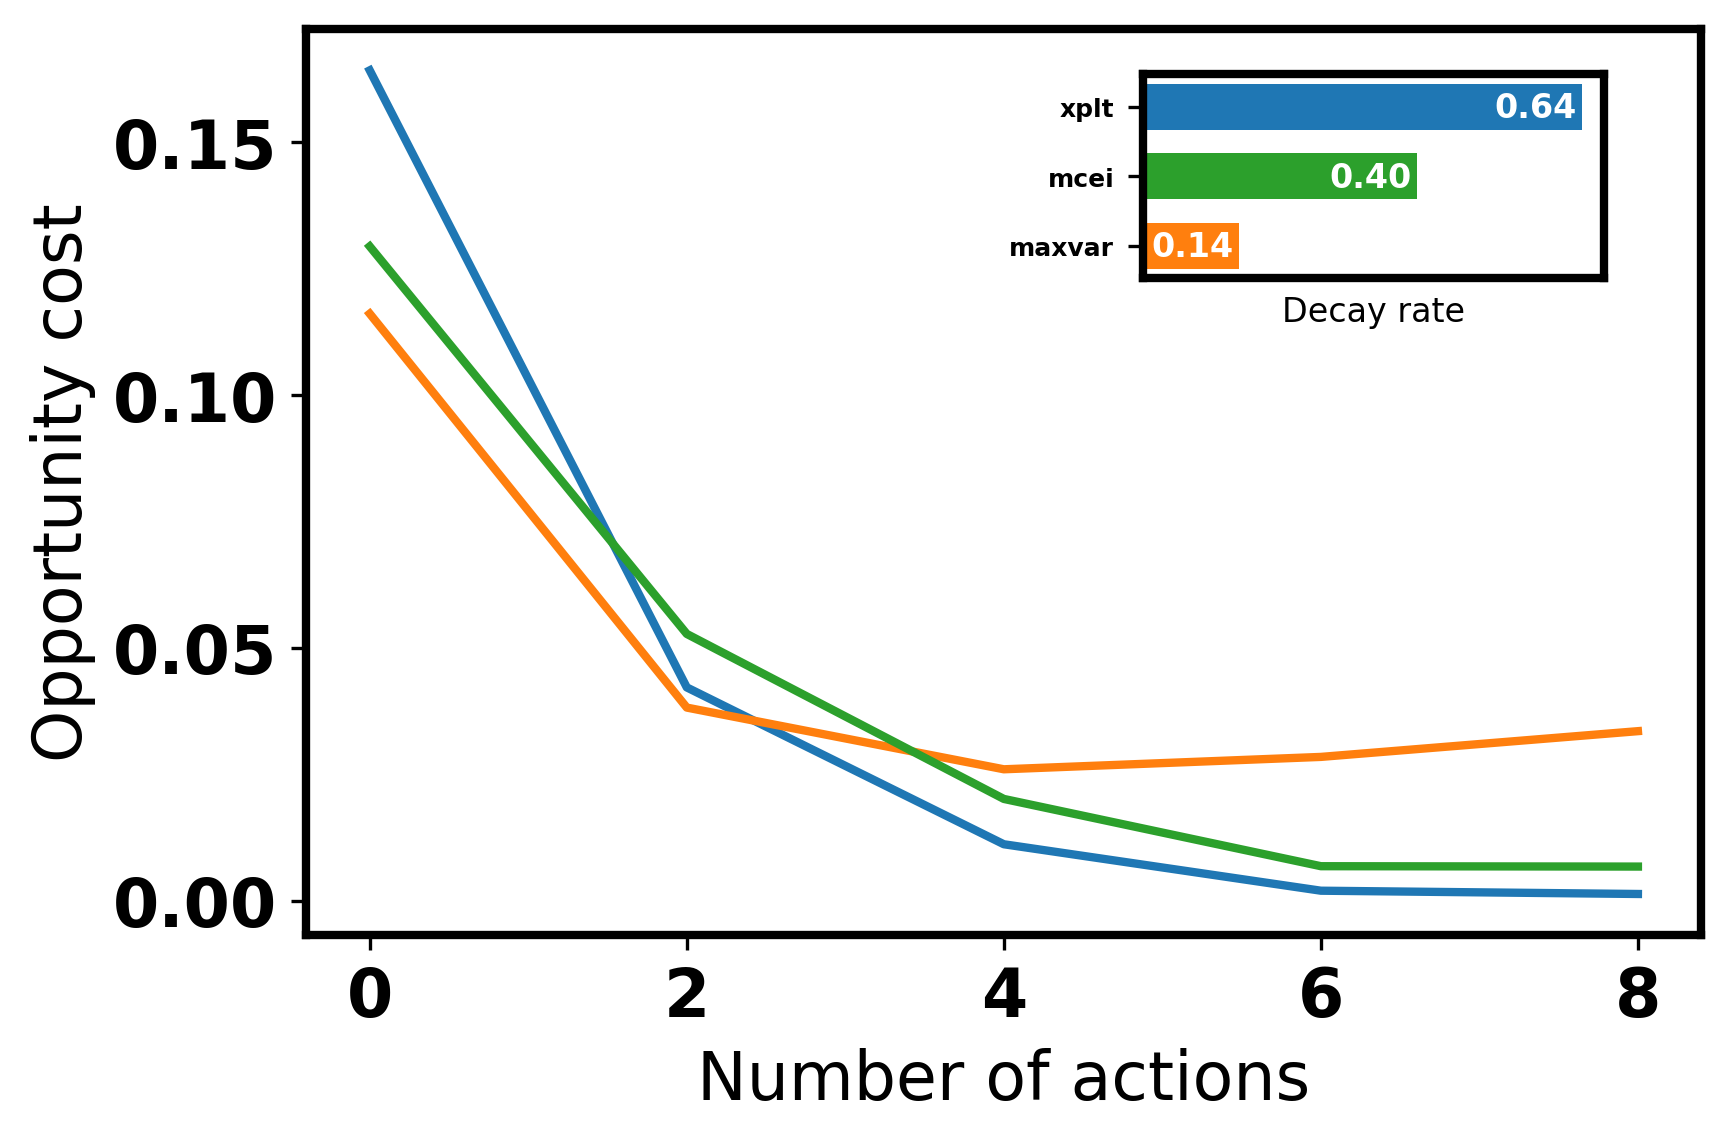

In [15]:
plot_sim_res(basic_sim_res['sim_res'])

Here we plot median OC versus number of experiments, taken over all the
simulations. We also obtain the 33rd and 66th percentiles for OC, again versus
number of experiments. Lower OC is better.

We also fit an exponential decay model to the median OC curve:

$$ OC(n) = A e^{-\lambda n}$$

This decay model is shown as dashed line. We indicate the decay rate
$\lambda$ for each policy in the inset bar plot. Larger decay rates are
indicative of better performance. We see for Model 0, the `xplt` policy -- the
**Pure Exploitation** policy -- performs best with a decay rate of 0.49.

## Model 1 Simulations

We now run similar simulations for Model 0. Just like the simulations above,
we specify the QOI model (OC) and simulation parameters in addition to the
other specifications we originally provided in our call to `/basic/suggest`.
Below, we will copy the request and add the requisite additional specifications.
Here, when we specify the OC model, we must also pass in the utility function
since Model 1 is a multivariate model. Passing in this utility function defines
the scalar quantity we wish to actually optimize, which is needed for the
OC performance metric.

In [16]:
import copy

mcei_sim_request = copy.deepcopy(mcei_request)

# Add OC metric, with the proper utility function
mcei_sim_request['model_specs']['oc'] = {
    "name": "holmes.simulator.qois.OpportunityCost",
    "params": {
        "optimizer": "{optimizer}",
        "rng": "{_rng}",
        "sim_fmodel": "{fmodel}",
        "utility_f": "{max_utility_f}"
    }
}

Then we specify other simulation parameters. Because Model 1 computationally
more expensive than Model 0, we reduce the number of simulations performed
so that the subsequent call does not take too long. We also request that the
QOI is calculated every other step instead of being calculated at each step,
using the `qoi_freq` parameter.

In [17]:
# Add some simulation parameters
mcei_sim_request['sim_params'] = {
    "num_sims": 32, # Run 32 simulations
    "qoi_freq": 2, # Calculate QOI every other step
    "qois": ["{oc}"], "y_qoi": "oc" # Compute and return OC as the QOI
}

Once the sim request dictionary is ready, we can call the simulation endpoint
at `/basic/simulate`.

In [18]:
# Send request
tic = timeit.default_timer()
mcei_sim_res = requests.post(BASE_URL + "/basic/simulate",
                             json = mcei_sim_request).json()
toc = timeit.default_timer()

print("Elapsed time = %4.2f seconds"%(toc - tic))

Elapsed time = 1954.02 seconds


Once the simulations are finished, we can plot the results. In fact, we'll plot
the results from both simulations by concatenating the simulation results.

      xplt: 0.64
    maxvar: 0.14
      mcei: 0.40
  max_mcei: 1.08


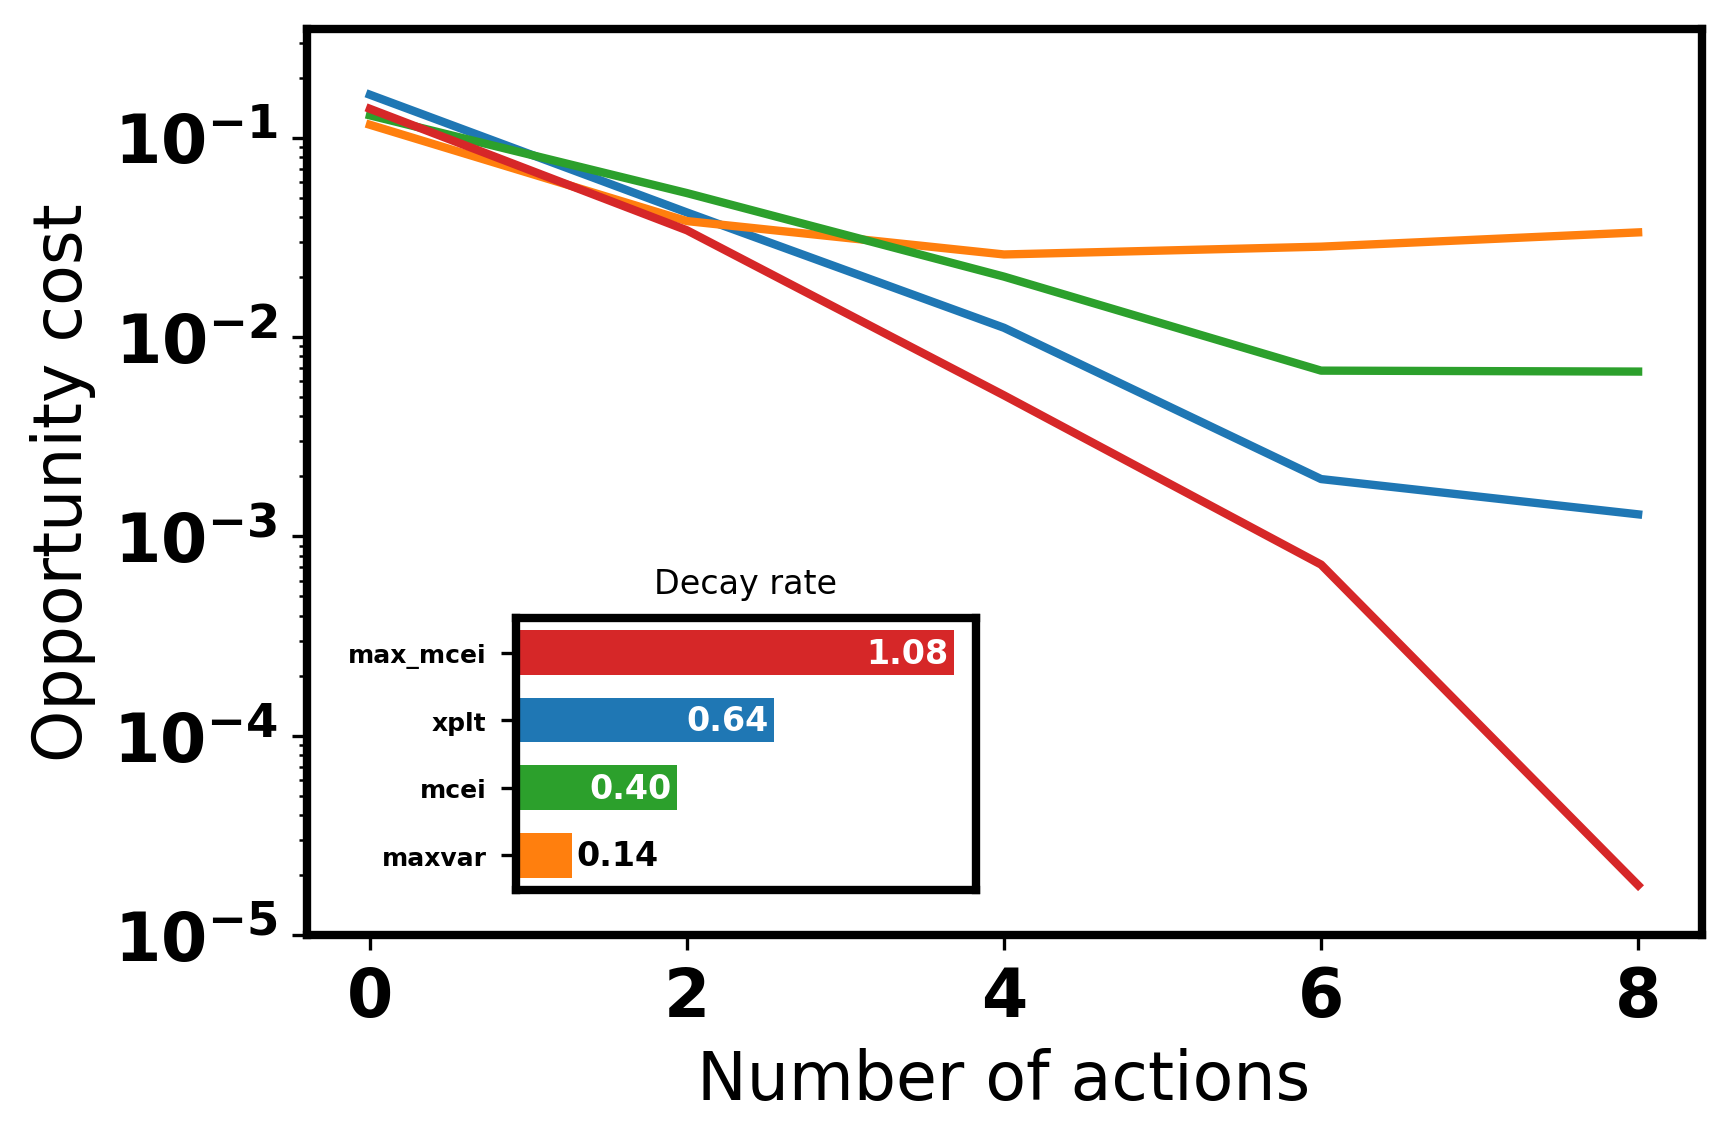

In [19]:
plot_sim_res(basic_sim_res['sim_res'] + mcei_sim_res['sim_res'],
             ylog=True, ylim=[1e-5, 0.35])

Here we see that the decay rate for Model 1 is more than twice than that of
Model 0, indicating Model 1 is advantageous for this problem.

# Model 2

Model 1 performs well but is slow. One reason is because the model
performs several **Monte Carlo samples** to evaluate the expectation
$\mathbb E[ u_\text{max}(\mathbf x) - u_\text{best}]^+$, and it does this for
several $\mathbf x$ to identify which such $\mathbf x$ maximizes this
expression.

The policy is fast enough to obtain individual suggestions, but performing the
large number of simulations to obtain statistically relevant results may be
prohibitively expensive. In what follows, we propose some alternative models and
policies that are faster to evaluate than `MCEI`. One easy way to lessen the
time is to reduce the number of time steps passed to Holmes. Above, we defined
it to be 25 time steps, but decreasing this can speed up results. If our
response has a relatively coarse time resolution, then this approach may be
appropriate.

Another alternative is to consider a different utility function for our
decision-making policy. Specifically, consider instead

$$u_\text{avg}(\mathbf x) = \mathbb E_t\left[f(\mathbf x, t\right)],$$

which is the **average** value of the response over all $t$. Contrast this
utility with our earlier aggregation $u_\text{max}$, which was the
**maximum** value of the response over all $t$.

By using $u_\text{avg}$, our decision-making strategy shifts to finding the
value $\mathbf x$ that has good response on average, and not necessarily the
one that produces a single good response at a specific time. For some problems
these two objectives may be related enough so that using $u_\text{avg}$ could
be a reliable proxy for the $u_\text{max}$ objective.

The computational advantage is that $u_\text{avg}$ is **linear** with respect
to the observed response.

$$u_\text{avg}(\mathbf x) = \frac{1}{n} \sum_{i=1}^n f(\mathbf x, i).$$

This linearity allows us to use the `GPEI` policy, which is just like the `MCEI`
policy in that both score $\mathbf x$ based on the expected improvement score
above, but `GPEI` uses a closed-form analytic formula rather than Monte Carlo
samples. We can only invoke this closed-form formula for linear utility
functions (which `GPEI` refers to as the `functional` parameter). Such linear
utility functions are characterized by coefficients $(\theta_1, ..., \theta_n)$
in a linear combination of the multiple outputs.

$$u_\text{linear}(\mathbf x) = \sum_{i=1}^n \theta_i f(\mathbf x, i).$$

In the case of averaging, the coefficients are all equal to $\theta_i = 1/n$ --
every time-step contributes equally to the utility value. Equivalently, we
can use a functional $\theta_i = 1$, which corresponds to the linear utility

$$u_\text{sum}(\mathbf x) = n\cdot u_\text{avg}(\mathbf x),$$

which also weights output variables with equal weight.

Below, we define this new policy using the `GPEIAcq` acquisition function
model, and specify the functional $\theta_i = 1$. We then use this acquisition
function in a similar manner as before.

In [20]:
gpei_request = {
    "model_specs": {
        "state": {
            "name": "holmes.state.GPBeliefState",
            "params": {
                "data[as_action_obs_data]": {
                    "actions[scale_to_zero_one]": "<actions>",
                    "obs[z_to_standard_z, bounded_to_z]": "<obs>" },
                "task_cov[exp_cov_mat]": { "inputs": time_points } } },

        "avg_gpei": {
            "name": "holmes.policies.AcquisitionFunctionPolicy",
            "params": {
                "acq_f": "{avg_gpei_acq_f}",
                "optimizer": "{optimizer}" } },

        "avg_gpei_acq_f": {
            "name": "holmes.policies.GPEIAcq",
            "params": {
                # Use the all-ones "functional" to do average of outputs
                "functional": np.ones(len(time_points)).tolist()
            }},

        "action_budget":  15 },

    "data_sources": {
        "actions[action_type]": actions,
        "obs[obs_type]": obs },

    "policies": ['{avg_gpei}']
}

# Send request
gpei_res = requests.post(BASE_URL + "/basic/suggest",
                         json = gpei_request).json()
# Print suggestions
pprint.pprint(gpei_res)

{'suggestions': [{'policy': 'avg_gpei', 'suggestion': [[0.6661609244415898]]}]}


We can also run simulations as well, just like how we ran simulations with
Model 1.

In [21]:
gpei_sim_request = copy.deepcopy(gpei_request)

gpei_sim_request['model_specs']['max_utility_f'] = {
    "name": "holmes.policies.MaxUtilityFunction" }

gpei_sim_request['model_specs']['oc'] = {
    "name": "holmes.simulator.qois.OpportunityCost",
    "params": {
        "optimizer": "{optimizer}",
        "rng": "{_rng}",
        "sim_fmodel": "{fmodel}",
        "utility_f": "{max_utility_f}"
    }
}

gpei_sim_request['sim_params'] = {
    "num_sims": 32,  "qoi_freq": 2, "qois": ["{oc}"], "y_qoi": "oc" }

# Make request
tic = timeit.default_timer()
gpei_sim_res = requests.post(BASE_URL + "/basic/simulate",
                             json = gpei_sim_request).json()
toc = timeit.default_timer()
print("Elapsed time = %4.2f seconds"%(toc - tic))

Elapsed time = 867.94 seconds


We plot the results along with past those from simulations.

      xplt: 0.64
    maxvar: 0.14
      mcei: 0.40
  max_mcei: 1.08
  avg_gpei: 0.57


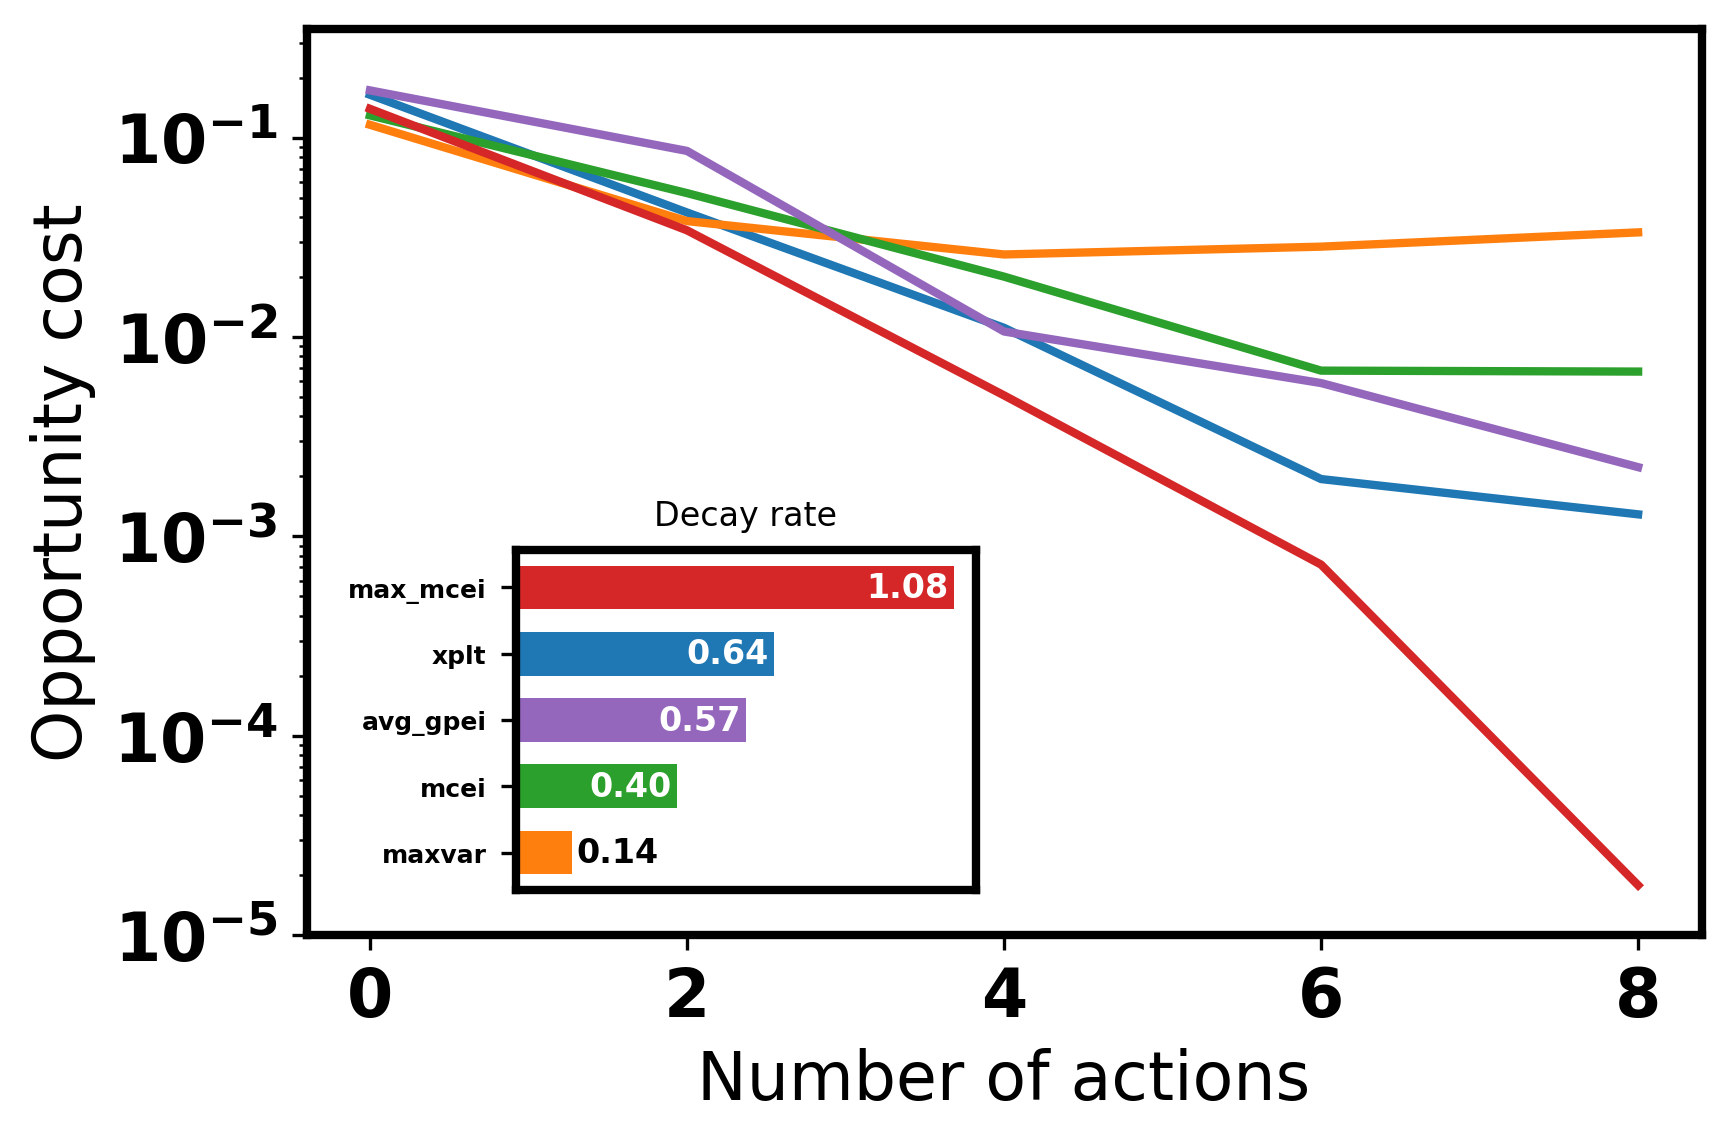

In [22]:
plot_sim_res(basic_sim_res['sim_res'] +
              mcei_sim_res['sim_res'] +
              gpei_sim_res['sim_res'],
             ylog=True, ylim=[1e-5, 0.35])

Here we see a decay rate of 0.49 for this new model. This rate is about the same
as the ones for the basic policies applied to Model 0, but still about half of
that of Model 1's performance.

# Model 3

Another way to model this is as a nested decision-making problem. We can imagine
scoring an input $\mathbf x$ in the following manner. For a fixed $\mathbf x$,
we consider the distribution for the values

$$\boldsymbol f(\mathbf x) = \
    \left[ f(\mathbf x, t_1), ..., f(\mathbf x, t_f)\right].$$

This is called a conditional distribution. We can use an auxiliary policy, here
called an **inner policy** to select a time $t_i$ based on this conditional
distribution. Suppose this inner policy selects such a $t_i$ based on maximizing
its own acquisition function $A_{\mathbf x}(t)$. We can use this to assign a
score for $\mathbf x$:

$$A(\mathbf x) = \max_t A_{\mathbf x}(t).$$

We'll call this a "pass-through nested policy" because the score for $\mathbf x$
is simply the best score over all time times $t$, according to some inner
policy. That is, the inner policy's score "passes through" as the score for
$\mathbf x$.

Below, we show how to use the `NestedAcq` class to model such an $A(\mathbf x)$.
We must specify the inner policy. Below we pick the `gpei` policy for the
inner policy, the built in `GPEI` model for scalar responses.

In [23]:
pass_thru_request = {
    "model_specs": {
        "state": {
            "name": "holmes.state.GPBeliefState",
            "params": {
                "data[as_action_obs_data]": {
                    "actions[scale_to_zero_one]": "<actions>",
                    "obs[z_to_standard_z, bounded_to_z]": "<obs>" },
                "task_cov[exp_cov_mat]": { "inputs": time_points } } },

        "pass_gpei": {
            "name": "holmes.policies.AcquisitionFunctionPolicy",
            "params": {
                "acq_f": "{pass_thru_acq_f}",
                "optimizer": "{optimizer}" } },

        "pass_thru_acq_f": {
            "name": "holmes.policies.NestedAcq",
            # gpei is the builtin GP policy for scalar outputs
            "params": { "base_policy": "{gpei}" } },

        # How total actions (including actions already performed)
        "action_budget":  15 },

    "data_sources": {
        "actions[action_type]": actions,
        "obs[obs_type]": obs },

    "policies": ['{pass_gpei}']
}

# Send request
tic = timeit.default_timer()
pass_thru_res = requests.post(BASE_URL + "/basic/suggest",
                              json = pass_thru_request).json()
toc = timeit.default_timer()
print("Elapsed time (pass_thru-GPEI) = %5.2f" % (toc - tic))

# Print suggestions
pprint.pprint(pass_thru_res)

Elapsed time (pass_thru-GPEI) =  1.66
{'suggestions': [{'policy': 'pass_gpei', 'suggestion': [[0.3984097661845436]]}],
 'warnings': ['(compile.models.suggest) invalid value encountered in subtract']}


As before, we can run some simulations.

In [24]:
pass_thru_sim_request = copy.deepcopy(pass_thru_request)

# Add OC metric, with the proper utility function
pass_thru_sim_request['model_specs']['max_utility_f'] = {
    "name": "holmes.policies.MaxUtilityFunction"
}

pass_thru_sim_request['model_specs']['oc'] = {
    "name": "holmes.simulator.qois.OpportunityCost",
    "params": {
        "optimizer": "{optimizer}",
        "rng": "{_rng}",
        "sim_fmodel": "{fmodel}",
        "utility_f": "{max_utility_f}"
    }
}

# Add some simulation parameters
pass_thru_sim_request['sim_params'] = {
    "num_sims": 32,  # Run 32 simulations per policy
    "qoi_freq": 2, # Calculate QOI every other step
    "qois": ["{oc}"],
    "y_qoi": "oc"
}

# Send request
tic = timeit.default_timer()
pass_thru_sim_res = requests.post(BASE_URL + "/basic/simulate",
                                  json=pass_thru_sim_request).json()
toc = timeit.default_timer()
print("Elapsed time = %4.2f seconds"%(toc - tic))

Elapsed time = 1022.72 seconds


We can now compare the results with previous models.

      xplt: 0.64
    maxvar: 0.14
      mcei: 0.40
  max_mcei: 1.08
  avg_gpei: 0.57
 pass_gpei: 0.16


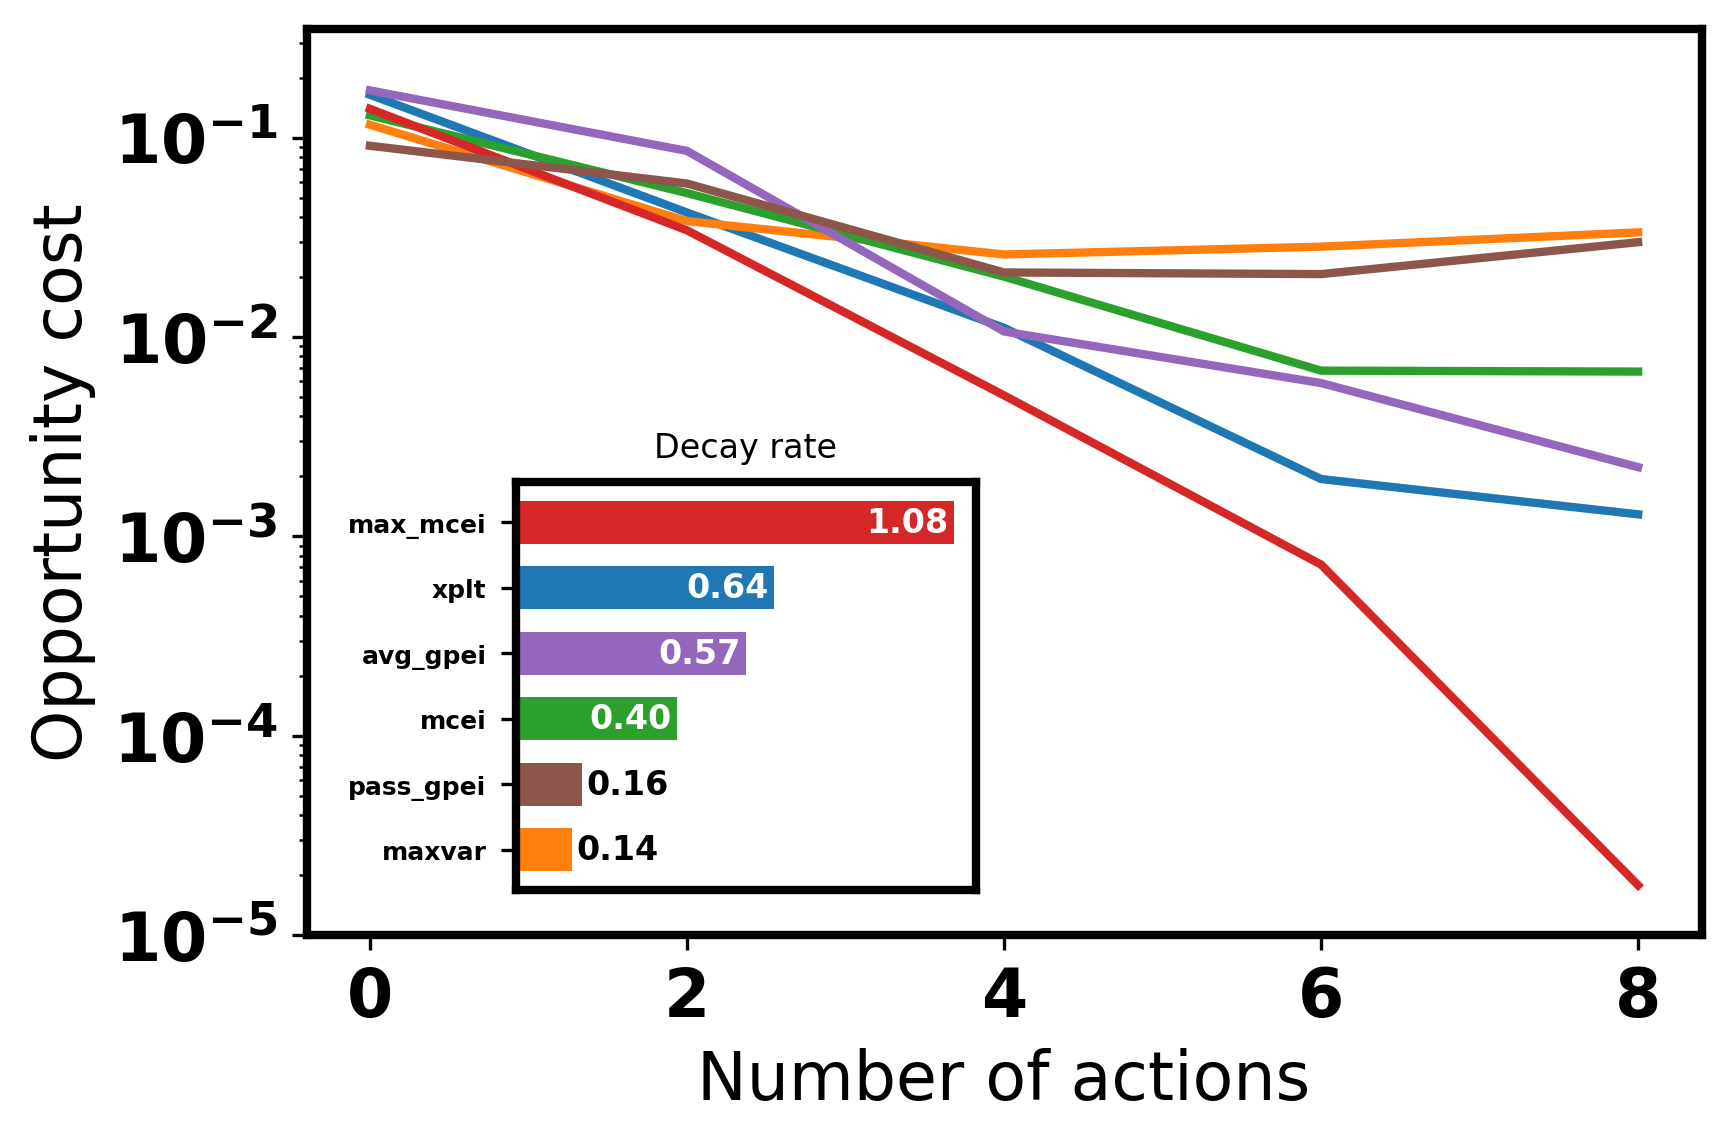

In [26]:
plot_sim_res(basic_sim_res['sim_res'] +
             mcei_sim_res['sim_res'] +
             gpei_sim_res['sim_res'] +
             pass_thru_sim_res['sim_res'],
             ylog=True, ylim=[1e-5, 0.35])

plt.savefig('out.pdf')

These simulation results show that the pass-through nested policy is
ineffective, attaining a decay rate of 0.36. In conclusion, Model 1 appears to
be best for this problem.

It is important to note that these results are **specific to this problem and
the initial data**. The policy / model performance and rankings can change as
more data is acquired. Therefore, it is important to rerun such simulations
occasionally throughout a campaign to ensure optimal selection of policies and
models.